In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import tqdm.auto as tqdm
import shutil

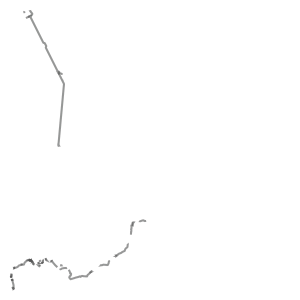

In [5]:
df_zetsteen = pd.concat(
    [
        # gpd.read_file("../ppt_selectie/zetsteen_ligging/Zetsteen shapefile traject 12-2.shp"),
        # gpd.read_file("../ppt_selectie/zetsteen_ligging/Zetsteen shapefile traject 13-7.shp")
        gpd.read_file(
            "data/dike_trajects/Zetsteen shapefile traject 12-2.shp"
        ),
        gpd.read_file(
            "data/dike_trajects/Zetsteen shapefile traject 13-7.shp"
        ),
        gpd.read_file(
            "data/dike_trajects/Zetsteen shapefile havendammen.shp"
        ),
    ]
)
geom_zetsteen = df_zetsteen.unary_union
geom_zetsteen

In [6]:
# df_observed = gpd.read_file("../test_output/supervisely_tags.gpkg")
# df_observed = df_observed[df_observed.intersects(geom_zetsteen)].copy()
# df_observed["geometry"] = df_observed.intersection(geom_zetsteen)
# df_observed = df_observed[df_observed.area > 0.01].copy()

# df_predicted = gpd.read_file("../test_output/fix_tags.gpkg")
# df_predicted = df_predicted[df_predicted.intersects(geom_zetsteen)].copy()
# df_predicted["geometry"] = df_predicted.intersection(geom_zetsteen)
# df_predicted = df_predicted[df_predicted.area > 0.01].copy()

In [7]:
df_observed = []
for p in tqdm.tqdm(
    pathlib.Path("../test_output").glob("supervisely_tags_20230714_*.gpkg")
):
    df = gpd.read_file(p)
    df = df[df.intersects(geom_zetsteen)].copy()
    df["geometry"] = df.intersection(geom_zetsteen)
    df = df[df.area > 0.01].copy()
    df_observed.append(df)
df_observed = gpd.GeoDataFrame(
    pd.concat(df_observed, ignore_index=True), geometry="geometry", crs=df.crs
)

df_predicted = []
for p in tqdm.tqdm(pathlib.Path("../test_output").glob("fix_tags_20230714_*.gpkg")):
    df = gpd.read_file(p)
    df = df[df.intersects(geom_zetsteen)].copy()
    df["geometry"] = df.intersection(geom_zetsteen)
    df = df[df.area > 0.01].copy()
    df_predicted.append(df)
df_predicted = gpd.GeoDataFrame(
    pd.concat(df_predicted, ignore_index=True), geometry="geometry", crs=df.crs
)

# Verwijder segmenten obv corrupte tiles
corrupt_files = []
for tile_path, group in df_predicted.groupby("tile_path"):
    tile_path = pathlib.Path(tile_path)
    # Goedkope manier om corrupte tiles te detecteren (<25kB)
    if tile_path.stat().st_size < 26000:
        print(f"{tile_path.name} lijkt corrupt te zijn, negeer")
        corrupt_files.append(group.index.to_numpy())
corrupt_files = np.hstack(corrupt_files)
df_predicted = df_predicted[~df_predicted.index.isin(corrupt_files)].copy()

# Bepaal fractie van voorspellingscategorieen in observaties
for pred_cat in df_predicted.category.unique():
    df_observed[f"pred_{pred_cat}"] = 0.0
for obs in df_observed.itertuples():
    idx_all = df_predicted.sindex.query(obs.geometry, predicate="intersects")
    all_matches = df_predicted.iloc[idx_all, :].copy()
    all_matches["geometry"] = all_matches.geometry.intersection(obs.geometry)
    for cat, catgroup in all_matches.groupby("category"):
        df_observed.at[obs.Index, f"pred_{cat}"] = (
            catgroup.unary_union.area / obs.geometry.area
        )

0it [00:00, ?it/s]

0it [00:00, ?it/s]

20230714 MUG Hoorn Enkhuizen orthomosaic deel 2_0.jpeg lijkt corrupt te zijn, negeer
20230714 MUG Hoorn Enkhuizen orthomosaic deel 2_1.jpeg lijkt corrupt te zijn, negeer
20230714 MUG Hoorn Enkhuizen orthomosaic deel 2_2.jpeg lijkt corrupt te zijn, negeer
20230714 MUG Hoorn Enkhuizen orthomosaic deel 3_12.jpeg lijkt corrupt te zijn, negeer
20230714 MUG Hoorn Enkhuizen orthomosaic deel 3_13.jpeg lijkt corrupt te zijn, negeer
20230714 MUG Hoorn Enkhuizen orthomosaic deel 4_83.jpeg lijkt corrupt te zijn, negeer
20230714 MUG Hoorn Enkhuizen orthomosaic deel 4_84.jpeg lijkt corrupt te zijn, negeer
20230714 MUG Hoorn Enkhuizen orthomosaic deel 4_85.jpeg lijkt corrupt te zijn, negeer
20230714 MUG Hoorn Enkhuizen orthomosaic deel 6_96.jpeg lijkt corrupt te zijn, negeer
20230714 MUG Hoorn Enkhuizen orthomosaic deel 6_97.jpeg lijkt corrupt te zijn, negeer
20230714 MUG Hoorn Enkhuizen orthomosaic deel 10_0.jpeg lijkt corrupt te zijn, negeer
20230714 MUG Hoorn Enkhuizen orthomosaic deel 10_4.jpeg l

## Unieke observatiecategorieen

In [8]:
print(df_observed.category.unique())

['gras steenbekleding' 'twijfel opschot' 'opschot']


## Unieke voorspellingscategorieen

In [9]:
df_predicted.category.unique()

array(['grass', 'road', 'stone', 'bush', 'water', 'grass road',
       'grass stone', 'shrub', 'road water', 'stone tree', 'tree',
       'road stone', 'shrub tree', 'bush grass', 'bush stone',
       'grass water', 'stone water'], dtype=object)

In [ ]:
selected_cat = "opschot"
prediction_cats = ["bush", "shrub", "tree", "shrub tree"]


df_predicted_truth = df_predicted[df_predicted.category.isin(prediction_cats)].copy()

df_observed["opschot_predicted"] = False
for obs in df_observed.itertuples():
    idx = df_predicted_truth.sindex.query(obs.geometry, predicate="intersects")
    df_observed.at[obs.Index, "opschot_predicted"] = len(idx) > 0

df_observed.to_file("../test_output/supervisely_tags.gpkg")
df_predicted.to_file("../test_output/fix_tags.gpkg")

print(f"{selected_cat=}")
print(f"{prediction_cats=}")

In [ ]:
# df_labeled = pd.read_csv("postprocessing/labeled_images.csv")
# for row in df_labeled.itertuples():
#     matches = list(pathlib.Path("data/tile_dataset").glob(f"*/tiles/{row.file_name}"))
#     assert len(matches) == 1
#     org_path = matches[0]
#     shutil.copyfile(org_path, pathlib.Path("postprocessing/labeled_images").joinpath(org_path.name))
#     org_xml_path = org_path.with_suffix(".jpeg.aux.xml")
#     shutil.copyfile(org_xml_path, pathlib.Path("postprocessing/labeled_images").joinpath(org_xml_path.name))
# df_labeled

for tile_path, group in df_observed.groupby("tile_path"):
    matches = list(
        pathlib.Path("data/tile_dataset").glob(
            f"*/tiles/{pathlib.Path(tile_path).name}"
        )
    )
    assert len(matches) == 1
    org_path = matches[0]
    shutil.copyfile(
        org_path, pathlib.Path("postprocessing/labeled_images").joinpath(org_path.name)
    )
    org_xml_path = org_path.with_suffix(".jpeg.aux.xml")
    shutil.copyfile(
        org_xml_path,
        pathlib.Path("postprocessing/labeled_images").joinpath(org_xml_path.name),
    )

## Geselecteerde observatiecategorie en geselecteerde voorspellingscategorieen

In [ ]:
df_observed_cat = df_observed.copy()
df_predicted_cat_all = df_predicted.copy()

# Add prediction category
df_predicted_cat_all.insert(df_predicted_cat_all.shape[1] - 2, "predicted_category", "")
df_predicted_cat_all.loc[
    df_predicted_cat_all.category.isin(prediction_cats), "predicted_category"
] = selected_cat

# Reduce observations to selected category
df_observed_cat = df_observed_cat[df_observed_cat.category == selected_cat].copy()

# Reduce predictions to selected category
df_predicted_cat = df_predicted_cat_all.copy()
df_predicted_cat = df_predicted_cat[
    df_predicted_cat.predicted_category == selected_cat
].copy()

In [ ]:
df_predicted_truth = df_predicted_cat.copy()
df_observed_truth = df_observed_cat.copy()

df_predicted_truth["opschot_observed"] = False
for pred in df_predicted_truth.itertuples():
    idx = df_observed_truth.sindex.query(pred.geometry, predicate="intersects")
    df_predicted_truth.at[pred.Index, "opschot_observed"] = len(idx) > 0

df_observed_truth["opschot_predicted"] = False
for obs in df_observed_truth.itertuples():
    idx = df_predicted_truth.sindex.query(obs.geometry, predicate="intersects")
    df_observed_truth.at[obs.Index, "opschot_predicted"] = len(idx) > 0

# df_predicted_truth.to_file("test_predicted.gpkg")
# df_observed_truth.to_file("test_observed.gpkg")

In [ ]:
# df_observed_truth["file_name"] = [pathlib.Path(p).name for p in df_observed_truth.tile_path]
# for labeled_row in df_labeled.itertuples():
#     group_observed = df_observed_truth[df_observed_truth.file_name == labeled_row.file_name].copy()
#     group_predicted = df_predicted_truth[df_predicted_truth.tile_fname == labeled_row.file_name].copy()

#     idxs = group_observed.sindex.query(group_predicted.geometry, predicate="intersects")
#     print(group_observed.shape, group_predicted.shape)

df_observed_truth.opschot_predicted.sum() / df_observed_truth.shape[0]
# for name, group in df_observed_truth.groupby("tile_path"):
# print(pathlib.Path(name).stem, int(group.opschot_predicted.sum() / group.shape[0] * 100) / 100, pathlib.Path(name).name in df_labeled.file_name.tolist())
# df_predicted.tile_path.tolist()

## Gegeven een voorspellingscategorie, hoeveel overlap hebben we met de geselecteerde observatie?

In [ ]:
df_predicted_cat_all["opschot_overlap"] = 0.0
for pred in df_predicted_cat_all.itertuples():
    idx = df_observed_cat.sindex.query(pred.geometry, predicate="intersects")
    if len(idx) == 0:
        continue
    obs_geom = df_observed_cat.geometry.iloc[idx].unary_union
    matching_pred = pred.geometry.intersection(obs_geom)
    df_predicted_cat_all.at[pred.Index, "opschot_overlap"] = (
        matching_pred.area / pred.geometry.area
    )

plt.close("all")
ncols = 3
nrows = np.ceil(len(df_predicted_cat_all.category.unique()) / ncols)
fig, axs = plt.subplots(nrows=int(nrows), ncols=ncols, figsize=(5 * ncols, 3 * nrows))
for counter, (cat, group) in enumerate(df_predicted_cat_all.groupby("category")):
    i = int(np.floor(counter / ncols))
    j = counter - i * ncols
    ax = axs[i, j]

    steps = np.linspace(-0.1, 1, 12) + 1e-6
    counts, bins = np.histogram(group.opschot_overlap, bins=steps)
    labels = []
    for i in range(1, len(bins)):
        if i == 1:
            labels.append(f"{bins[i]:.1f}")
        else:
            labels.append(f"{bins[i-1]:.1f} - {bins[i]:.1f}")

    ax.barh(labels, counts)
    ax.set_xlim([0, len(group)])
    ax.grid()
    ax.set_title(
        f"Prediction category: {cat}, n={len(group)}\n Observation {selected_cat} overlap given prediction category"
    )
    ax.set_xlabel("Count")
    ax.set_ylabel("Fraction overlap")
fig.tight_layout()

## Gegeven de geselecteerde observatie, hoeveel overlap hebben we met een voorspellingscategorie?

In [ ]:
plt.close("all")
ncols = 3
nrows = np.ceil(len(df_predicted_cat_all.category.unique()) / ncols)
fig, axs = plt.subplots(nrows=int(nrows), ncols=ncols, figsize=(5 * ncols, 3 * nrows))
for counter, (cat, group) in enumerate(df_predicted_cat_all.groupby("category")):
    i = int(np.floor(counter / ncols))
    j = counter - i * ncols
    ax = axs[i, j]

    df_observed_cat["opschot_overlap"] = 0.0
    for obs in df_observed_cat.itertuples():
        idx = group.sindex.query(obs.geometry, predicate="intersects")
        if len(idx) == 0:
            continue
        pred_geom = group.geometry.iloc[idx].unary_union
        matching_obs = obs.geometry.intersection(pred_geom)
        df_observed_cat.at[obs.Index, "opschot_overlap"] = (
            matching_obs.area / obs.geometry.area
        )

    steps = np.linspace(-0.1, 1, 12) + 1e-6
    counts, bins = np.histogram(df_observed_cat.opschot_overlap, bins=steps)
    labels = []
    for i in range(1, len(bins)):
        if i == 1:
            labels.append(f"{bins[i]:.1f}")
        else:
            labels.append(f"{bins[i-1]:.1f} - {bins[i]:.1f}")

    ax.barh(labels, counts)
    ax.set_xlim([0, len(df_observed_cat)])
    ax.grid()
    ax.set_title(
        f"Prediction category: {cat}\n Prediction overlap given observation {selected_cat}, n={len(df_observed_cat)}"
    )
    ax.set_xlabel("Count")
    ax.set_ylabel("Fraction overlap")
fig.tight_layout()

## Neem aan dat de geselecteerde voorspellingscategorieen overeenkomen met de geselecteerde observatiecategorie.
## Gegeven de voorspelling, hoeveel overlap hebben we met de geselecteerde observatie categorie?

In [ ]:
df_observed_cat["opschot_overlap"] = 0.0
for obs in df_observed_cat.itertuples():
    idx = df_predicted_cat.sindex.query(obs.geometry, predicate="intersects")
    if len(idx) == 0:
        continue
    pred_geom = df_predicted_cat.geometry.iloc[idx].unary_union
    matching_obs = obs.geometry.intersection(pred_geom)
    df_observed_cat.at[obs.Index, "opschot_overlap"] = (
        matching_obs.area / obs.geometry.area
    )

steps = np.linspace(-0.1, 1, 12) + 1e-6
counts, bins = np.histogram(df_observed_cat.opschot_overlap, bins=steps)
labels = []
for i in range(1, len(bins)):
    if i == 1:
        labels.append(f"{bins[i]:.1f}")
    else:
        labels.append(f"{bins[i-1]:.1f} - {bins[i]:.1f}")

plt.close("all")
fig, ax = plt.subplots()
ax.barh(labels, counts)
ax.set_xlim([0, len(df_observed_cat)])
ax.grid()
ax.set_title(
    f"Prediction overlap given observation\nObserved category: {selected_cat}, n={len(df_observed_cat)}\n Selected prediction categories: {', '.join(prediction_cats)}"
)
ax.set_xlabel("Count")
ax.set_ylabel("Fraction overlap");

## Neem aan dat de geselecteerde voorspellingscategorieen overeenkomen met de geselecteerde observatiecategorie.
## Gegeven de geselecteerde observatie categorie, hoeveel overlap hebben we met de geselecteerde voorspelling?

In [ ]:
df_predicted_cat["opschot_overlap"] = 0.0
for pred in df_predicted_cat.itertuples():
    idx = df_observed_cat.sindex.query(pred.geometry, predicate="intersects")
    if len(idx) == 0:
        continue
    obs_geom = df_observed_cat.geometry.iloc[idx].unary_union
    matching_pred = pred.geometry.intersection(obs_geom)
    df_predicted_cat.at[pred.Index, "opschot_overlap"] = (
        matching_pred.area / pred.geometry.area
    )

steps = np.linspace(-0.1, 1, 12) + 1e-6
counts, bins = np.histogram(df_predicted_cat.opschot_overlap, bins=steps)
labels = []
for i in range(1, len(bins)):
    if i == 1:
        labels.append(f"{bins[i]:.1f}")
    else:
        labels.append(f"{bins[i-1]:.1f} - {bins[i]:.1f}")

plt.close("all")
fig, ax = plt.subplots()
ax.barh(labels, counts)
ax.set_xlim([0, len(df_predicted_cat)])
ax.grid()
ax.set_title(
    f"Observation overlap given prediction\nObserved category: {selected_cat}\n Selected prediction categories: {', '.join(prediction_cats)}, n={len(df_predicted_cat)}"
)
ax.set_xlabel("Count")
ax.set_ylabel("Fraction overlap");